# LightGBM Tuning

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NAME = 'lightgbm'

In [5]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
)

In [6]:
sweep_configuration = {
    "name": f"{NAME}-expanding-window",
    "method": "random",
    "metric": {"goal": "minimize", "name": "WIS"},  
    "parameters": {
        "model": {"values": [NAME]},  
        "multiple_series": {"values": [False]},
        "use_covariates" :  {"values" : [True, False]},
        "use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True, False]},
        "use_static_covariates" :  {"values" : [False]},
        "lags": {"values": [8]},
        "lags_past_covariates": {"values": [8]},
        "lags_future_covariates": {"values": [(0,4)]},
        "num_leaves": {"values": [10, 20, 31, 40, 50]},  # Number of leaves
        "max_depth": {"values": [-1, 5, 10, 15, 20]},  # Max depth of trees
        "learning_rate": {"values": [0.005, 0.01, 0.05, 0.1, 0.2]},  # Learning rate
        "n_estimators": {"values": [250, 500, 1000, 2000, 5000]},  # Number of boosting rounds
        "min_child_samples": {"values": [10, 20, 30]},  # Minimum child samples per leaf
        "subsample": {"values": [0.8, 0.9, 1.0]},  # Subsampling ratio
        "colsample_bytree": {"values": [0.8, 0.9, 1.0]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0, 0.25, 0.5, 1.0]},  # L1 regularization
        "reg_lambda": {"values": [0, 0.25, 0.5, 1.0]},  # L2 regularization
        "subsample_freq": {"values": [0, 1, 2, 5]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0, 0.1, 0.2]},  # Minimum gain to split
        "max_bin": {"values": [510, 1024, 2048]},  # Maximum number of bins
    }
}

In [7]:
sweep_configuration = {
    "name": f"{NAME}-expanding-window",
    "method": "random",
    "metric": {"goal": "minimize", "name": "WIS"},  
    "parameters": {
        "model": {"values": [NAME]},  
        "multiple_series": {"values": [False]},
        "use_covariates" :  {"values" : [True, False]},
        "use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True, False]},
        "use_static_covariates" :  {"values" : [False]},
        "lags": {"values": [8]},
        "lags_past_covariates": {"values": [8]},
        "lags_future_covariates": {"values": [(0,4)]},
        "num_leaves": {"values": [10, 20, 31, 40, 50]},  # Number of leaves
        "max_depth": {"values": [-1, 5, 10, 15, 20]},  # Max depth of trees
        "learning_rate": {"values": [0.005, 0.01, 0.05, 0.1, 0.2]},  # Learning rate
        "n_estimators": {"values": [250, 500, 1000, 2000, 5000]},  # Number of boosting rounds
        "min_child_samples": {"values": [10, 20, 30]},  # Minimum child samples per leaf
        "subsample": {"values": [1.0]},  # Subsampling ratio
        "colsample_bytree": {"values": [1.0]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0]},  # L1 regularization
        "reg_lambda": {"values": [0]},  # L2 regularization
        "subsample_freq": {"values": [0]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0, 0.1, 0.2]},  # Minimum gain to split
        "max_bin": {"values": [510, 1024, 2048]},  # Maximum number of bins
    }
}

### Load data

In [8]:
def get_season_start(start_year):
    return pd.to_datetime(Week(start_year, 40, system="iso").enddate())

def get_season_end(start_year):
    return pd.to_datetime(Week(start_year + 1, 39, system="iso").enddate())

def train_validation_split(series, validation_year):
    validation_end = get_season_end(validation_year)
    train_end = get_season_end(validation_year - 1)

    ts_validation = series[:validation_end]
    ts_train = series[:train_end]
    
    return ts_train, ts_validation

In [10]:
get_season_end(2023)

Timestamp('2024-09-29 00:00:00')

In [11]:
get_season_start(2024)

Timestamp('2024-10-06 00:00:00')

In [13]:
targets, covariates = load_realtime_training_data()

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


In [14]:
targets_train, targets_validation = train_validation_split(targets, 2022)

<Axes: xlabel='date'>

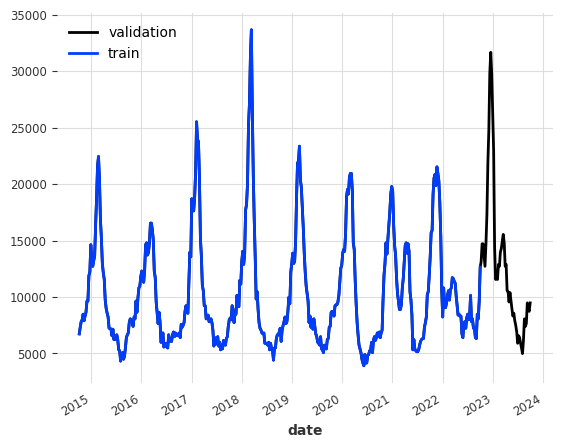

In [15]:
targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

### Block CV

In [9]:
# Block CV
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        
        **SHARED_ARGS
    )
    
    scores = []
    k=0
    for train, validation, cov in zip(targets_train, targets_validation, covariates):
        k+=1
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{k}' : score})
        # model.reset()?
            
    avg_score = np.mean(scores) # average across all validation periods
    std = np.std(scores)
    var = np.var(scores)
    
    wandb.log({'WIS_std' : std,
               'WIS_var' : var})

    return avg_score

### Simple validation

In [10]:
# Simple validation
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    train = targets_train
    validation = targets_validation
    cov = covariates
    
    if use_features:
        ts_features = load_features(lag=8)
        cov = cov.slice_intersect(ts_features) # features start a bit later because of rolling window
        ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    
    score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                     HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)

    return score

### Multiple runs

In [11]:
RANDOM_SEEDS = [1, 2, 3]

In [12]:
# Multiple runs
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    train = targets_train
    validation = targets_validation
    cov = covariates
    
    if use_features:
        ts_features = load_features(lag=8)
        cov = cov.slice_intersect(ts_features) # features start a bit later because of rolling window
        ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    
    
    scores = []
    for seed in RANDOM_SEEDS:
        model.model_params['random_state'] = seed
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{seed}' : score})
        model.reset_model()
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Expanding window

In [16]:
VALIDATION_YEARS = [2018, 2019, 2022, 2023]

In [17]:
# Expanding window
def objective(config):
    multiple_series = config.multiple_series
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = LightGBMModel(
        lags=config.lags,
        lags_past_covariates=config.lags_past_covariates if use_covariates else None,
        lags_future_covariates=config.lags_future_covariates if use_encoders else None,
        num_leaves=config.num_leaves,
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        n_estimators=config.n_estimators,
        min_child_samples=config.min_child_samples, 
        subsample=config.subsample, 
        colsample_bytree=config.colsample_bytree,  
        reg_alpha=config.reg_alpha,  # L1 regularization
        reg_lambda=config.reg_lambda,  # L2 regularization
        subsample_freq=config.subsample_freq, 
        min_split_gain=config.min_split_gain,  
        max_bin=config.max_bin,  
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        verbose=-1,
        likelihood="quantile",
        quantiles=QUANTILES,
        
        **SHARED_ARGS
    )
    
    
    scores = []
    for validation_year in VALIDATION_YEARS:
        targets_train, targets_validation = train_validation_split(targets, validation_year)
        score = compute_validation_score(model, targets_train, targets_validation, covariates if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS, enable_optimization=False)
        scores.append(score)
        wandb.log({f'WIS_{validation_year}' : score})
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Run tuning

In [18]:
def main():
    run = wandb.init()
    score = objective(wandb.config)
    wandb.log({"WIS": score})
    run.finish()

In [19]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="realtime-lightgbm-expanding-window")

Create sweep with ID: rbid04k0
Sweep URL: https://wandb.ai/dwolffram-karlsruhe-institute-of-technology/realtime-lightgbm-expanding-window/sweeps/rbid04k0


In [ ]:
wandb.agent(sweep_id, function=main, count=1000)

wandb: Agent Starting Run: nrsssgl9 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,352.14289
WIS_2018,226.20798
WIS_2019,272.76521
WIS_2022,492.61342
WIS_2023,416.98493


wandb: Agent Starting Run: 0yi0ty5n with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,335.5173
WIS_2018,199.78099
WIS_2019,251.66479
WIS_2022,476.98517
WIS_2023,413.63827


502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iri3xz6y with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wa

WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,338.67596
WIS_2018,222.39245
WIS_2019,251.84541
WIS_2022,476.83563
WIS_2023,403.63036


wandb: Agent Starting Run: o1diwu7d with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,364.07474
WIS_2018,258.97662
WIS_2019,248.97233
WIS_2022,519.55422
WIS_2023,428.79579


wandb: Agent Starting Run: 48mdk3dr with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,383.41157
WIS_2018,261.55946
WIS_2019,311.87625
WIS_2022,506.6285
WIS_2023,453.58206


wandb: Agent Starting Run: d7h5p996 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,349.34421
WIS_2018,230.01138
WIS_2019,277.09726
WIS_2022,481.47547
WIS_2023,408.79272


wandb: Agent Starting Run: w7lawek4 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,346.44295
WIS_2018,231.11936
WIS_2019,274.63151
WIS_2022,473.3822
WIS_2023,406.63871


wandb: Agent Starting Run: 8hb1rdh5 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,352.08999
WIS_2018,231.30507
WIS_2019,277.61599
WIS_2022,480.98296
WIS_2023,418.45594


wandb: Agent Starting Run: 5jpyjmuj with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,360.59617
WIS_2018,254.51862
WIS_2019,254.27265
WIS_2022,514.41947
WIS_2023,419.17393


wandb: Agent Starting Run: okb68u06 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,348.87587
WIS_2018,233.27701
WIS_2019,272.00955
WIS_2022,483.23203
WIS_2023,406.9849


wandb: Agent Starting Run: jwky2dhq with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,361.5941
WIS_2018,263.4126
WIS_2019,274.4605
WIS_2022,495.29426
WIS_2023,413.20904


wandb: Agent Starting Run: svxwxixi with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 15
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,335.46589
WIS_2018,205.98162
WIS_2019,236.49225
WIS_2022,493.37897
WIS_2023,406.01072


wandb: Agent Starting Run: fv4ckw59 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,363.32117
WIS_2018,268.31471
WIS_2019,271.01375
WIS_2022,495.94188
WIS_2023,418.01434


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hwdes5rg with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,373.39536
WIS_2018,256.91754
WIS_2019,296.78345
WIS_2022,495.3713
WIS_2023,444.50915


wandb: Agent Starting Run: 6l4oic2n with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,340.19611
WIS_2018,206.5737
WIS_2019,239.52095
WIS_2022,500.83088
WIS_2023,413.85891


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u7e7gwaf with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,349.31768
WIS_2018,237.32226
WIS_2019,284.4376
WIS_2022,469.10185
WIS_2023,406.40902


wandb: Agent Starting Run: mergu3r0 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,389.80013
WIS_2018,269.14277
WIS_2019,291.08903
WIS_2022,542.73893
WIS_2023,456.2298


wandb: Agent Starting Run: 8p8r72jz with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,465.78854
WIS_2018,341.71955
WIS_2019,407.88327
WIS_2022,583.25552
WIS_2023,530.29581


wandb: Agent Starting Run: 4or7lj4q with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,364.58911
WIS_2018,220.57825
WIS_2019,283.21602
WIS_2022,522.42129
WIS_2023,432.14087


wandb: Agent Starting Run: 6zald5t8 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,337.91044
WIS_2018,197.28834
WIS_2019,253.36509
WIS_2022,484.63661
WIS_2023,416.35174


wandb: Agent Starting Run: 46k2noxl with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,338.82844
WIS_2018,207.22939
WIS_2019,251.88926
WIS_2022,488.29351
WIS_2023,407.90159


wandb: Agent Starting Run: 1y60dxmy with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,355.0942
WIS_2018,232.56384
WIS_2019,292.67027
WIS_2022,474.12894
WIS_2023,421.01375


wandb: Agent Starting Run: 5c3d20mt with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,352.90368
WIS_2018,239.39561
WIS_2019,285.22373
WIS_2022,476.76404
WIS_2023,410.23134


wandb: Agent Starting Run: 0jpb0uf5 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,375.17941
WIS_2018,261.75038
WIS_2019,284.73444
WIS_2022,511.21448
WIS_2023,443.01836


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nnrp8nxk with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.005
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,365.37985
WIS_2018,251.11285
WIS_2019,296.04272
WIS_2022,488.4904
WIS_2023,425.87341


wandb: Agent Starting Run: 17h4vbyt with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 5
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,337.02807
WIS_2018,207.73817
WIS_2019,263.40064
WIS_2022,472.35693
WIS_2023,404.61652


wandb: Agent Starting Run: rcaaqxjg with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,348.14885
WIS_2018,232.86003
WIS_2019,271.94517
WIS_2022,481.65194
WIS_2023,406.13826


wandb: Agent Starting Run: sntojq10 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,354.26504
WIS_2018,200.25166
WIS_2019,280.13337
WIS_2022,496.63752
WIS_2023,440.03762


wandb: Agent Starting Run: nbcicxfq with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,358.83691
WIS_2018,263.09207
WIS_2019,279.28868
WIS_2022,479.98864
WIS_2023,412.97826


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4cpczodu with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,347.99385
WIS_2018,232.15519
WIS_2019,275.5862
WIS_2022,476.14347
WIS_2023,408.09056


wandb: Agent Starting Run: ins8tlct with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 250
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,343.48578
WIS_2018,218.72045
WIS_2019,272.81805
WIS_2022,472.73738
WIS_2023,409.66725


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6gg6kxzw with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,361.98946
WIS_2018,261.28898
WIS_2019,275.77502
WIS_2022,490.12508
WIS_2023,420.76874


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rscwlj3d with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_encoders: False
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WIS,▁
WIS_2018,▁
WIS_2019,▁
WIS_2022,▁
WIS_2023,▁
WIS_std,▁
WIS,348.60447
WIS_2018,233.04713
WIS_2019,276.55795
WIS_2022,476.8863
WIS_2023,407.92651


wandb: Agent Starting Run: 9x9gyviy with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: False
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 10
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_encoders: True
wandb: 	use_features: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
